In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# 함수 정의

In [2]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 데이터의 분산도 시각화 확인
def check_dist(data, columns):
    col_len = len(columns)
    num_col = 4
    num_row = round(col_len/num_col)
    fig, ax = plt.subplots(num_row, num_col, figsize=(12, 5*num_row))
    for count in range(col_len):
        row=int(count/num_col)
        col=count%num_col
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
    plt.show()

# 모델 별 RMSE 점수 
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

# 모델 하이퍼 파라미터 튜닝 GridSearch
def my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(train, y)
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

# 아래 두 함수는 예측값을 expm 하여 반환함을 주의
def train_and_predict(model,train,y,test):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    return prediction

def AveragingBlending(models, x, y, sub_x):
    for model in models : 
        model.fit(x.values, y)
    
    predictions = np.column_stack([
        np.expm1(model.predict(sub_x.values)) for model in models
    ])
    return np.mean(predictions, axis=1)


def save_submission(prediction, prefix, post_fix):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_{}.csv'.format(data_dir, prefix, post_fix)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 데이터 불러오기 및 전처리

### 데이터 각 항목의 의미
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [3]:
# 데이터 불러오기
data_dir = join(os.getenv("HOME"),"aiffel","kaggle_kakr_housing","data") 

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

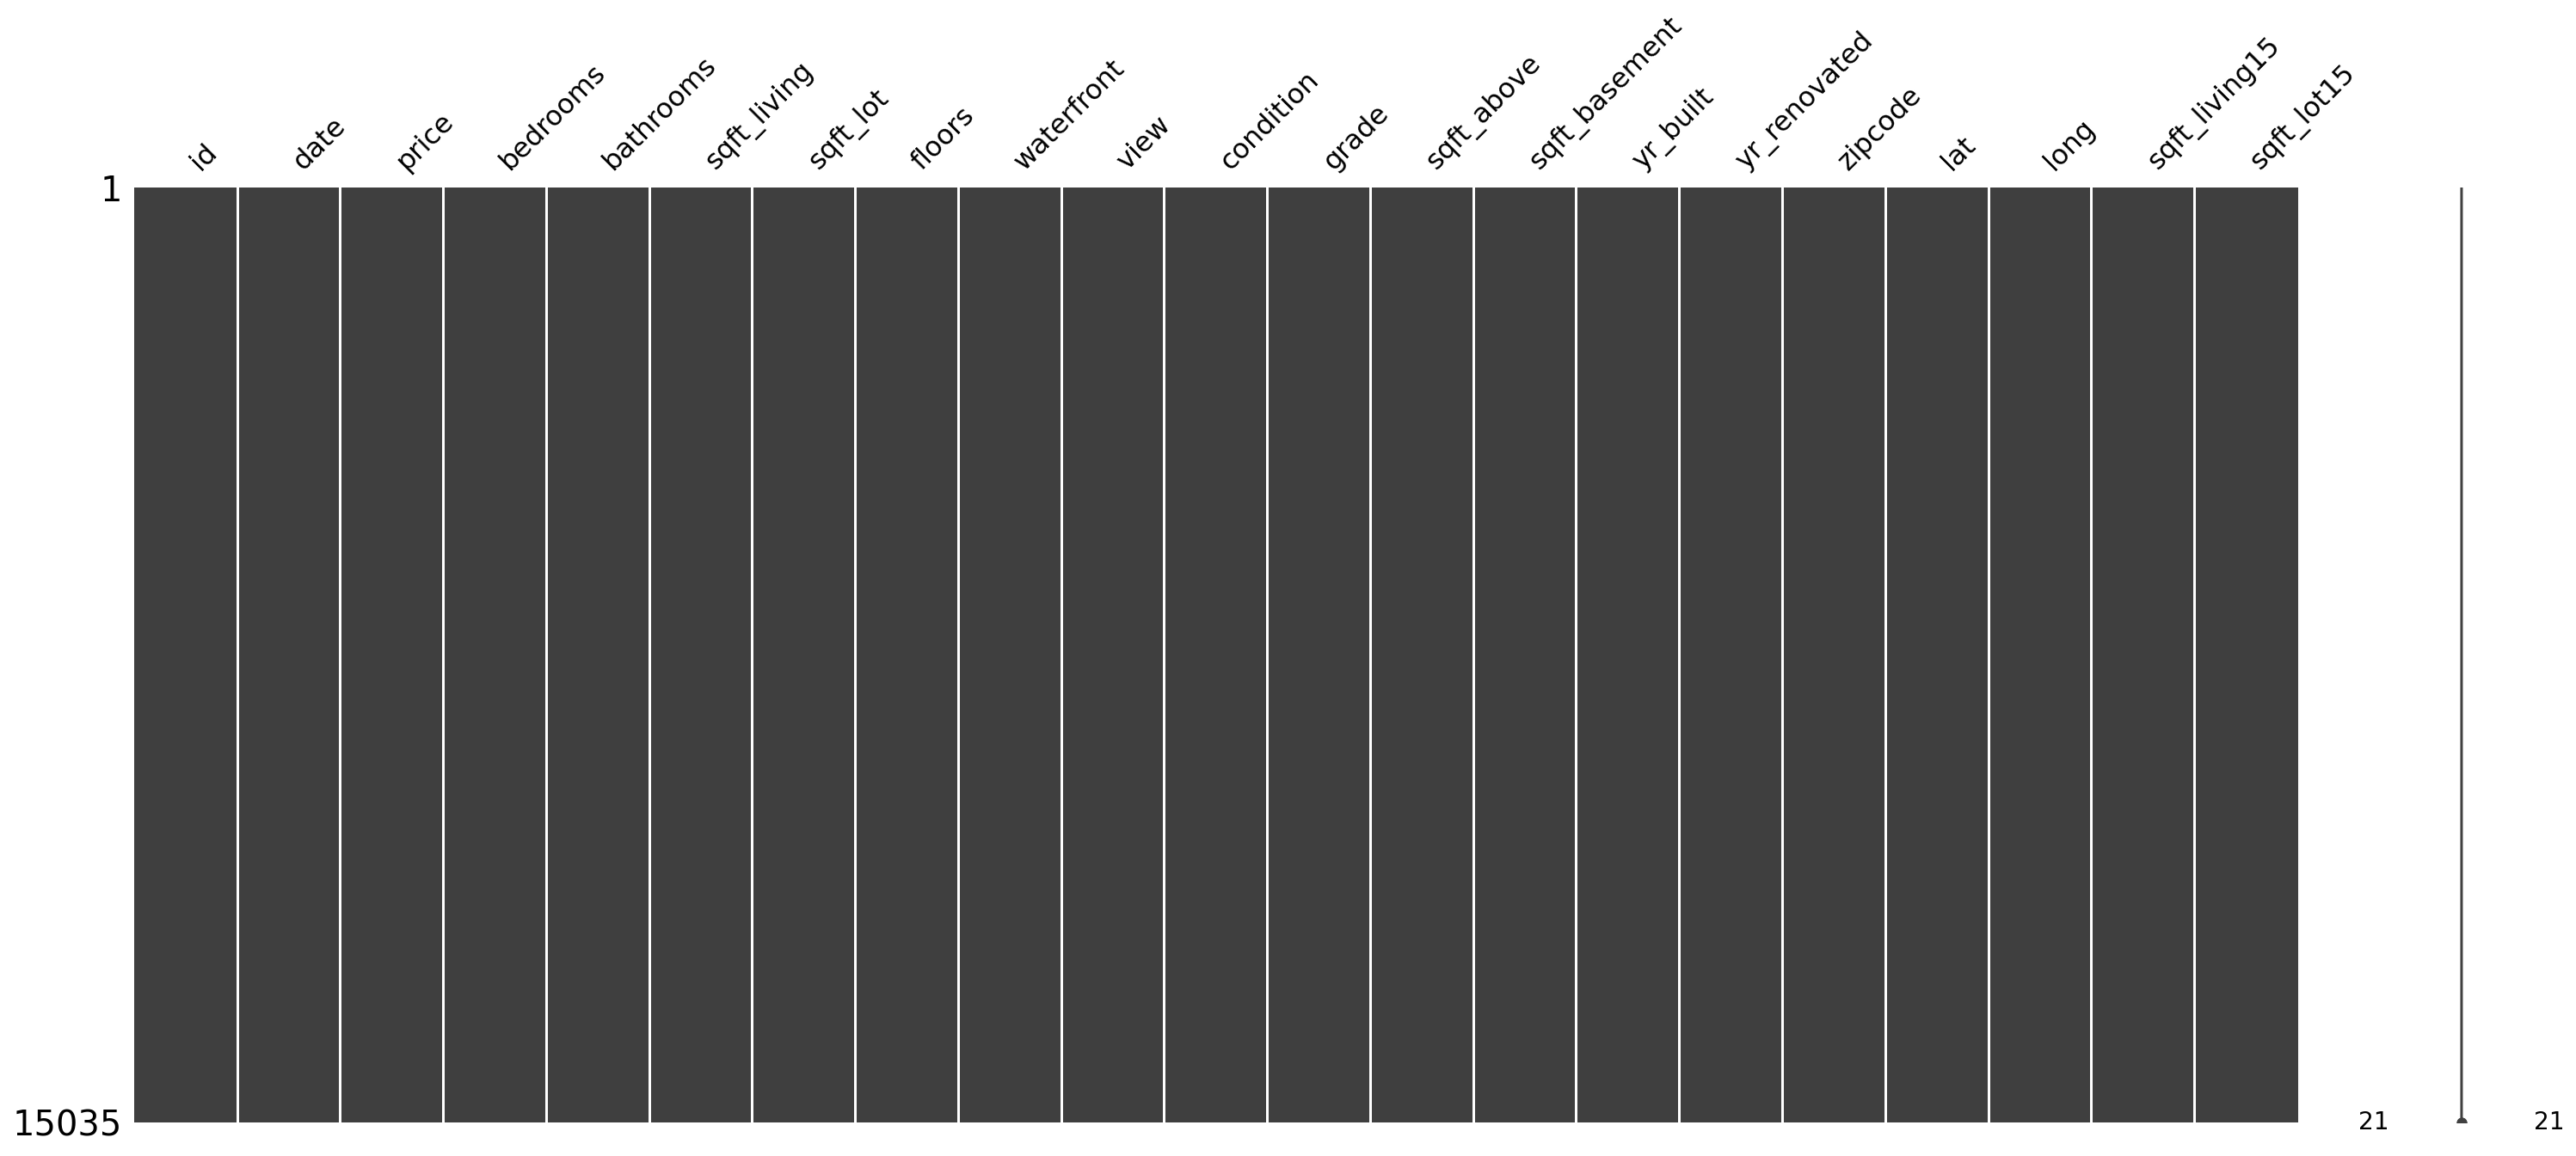

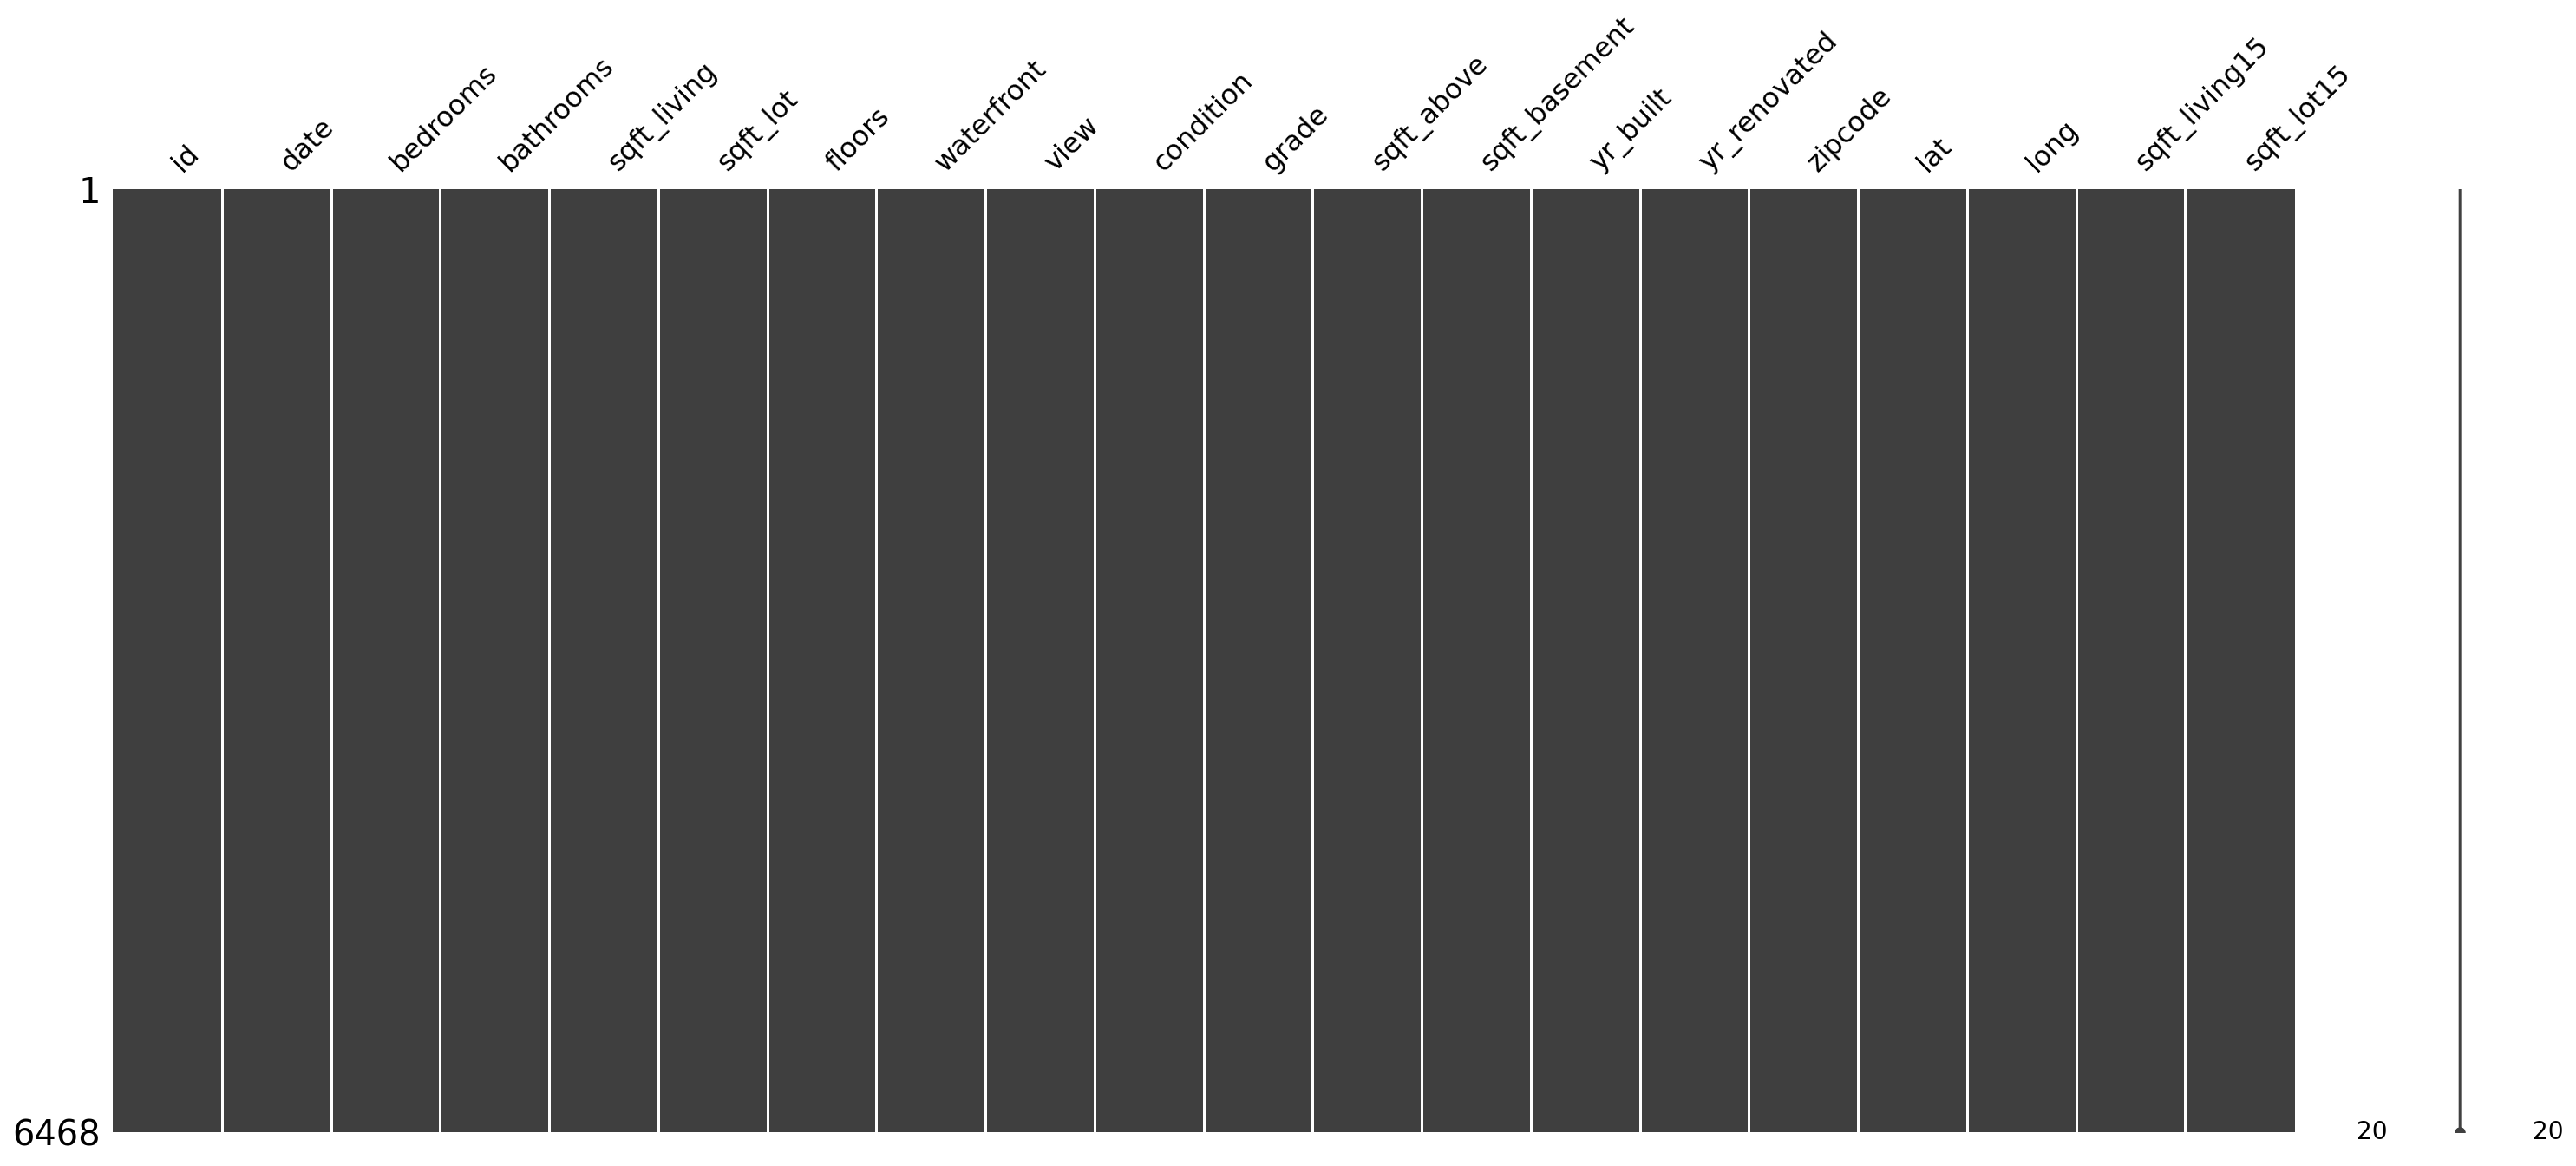

In [4]:
# 결측치 확인
msno.matrix(train)
msno.matrix(test)

In [5]:
# 타겟 생성 및 불필요 컬럼 삭제
y = train['price']
del train['price']
del train['id']
del test['id']

# date 정수화
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#print(train.columns)
#print(test.columns)

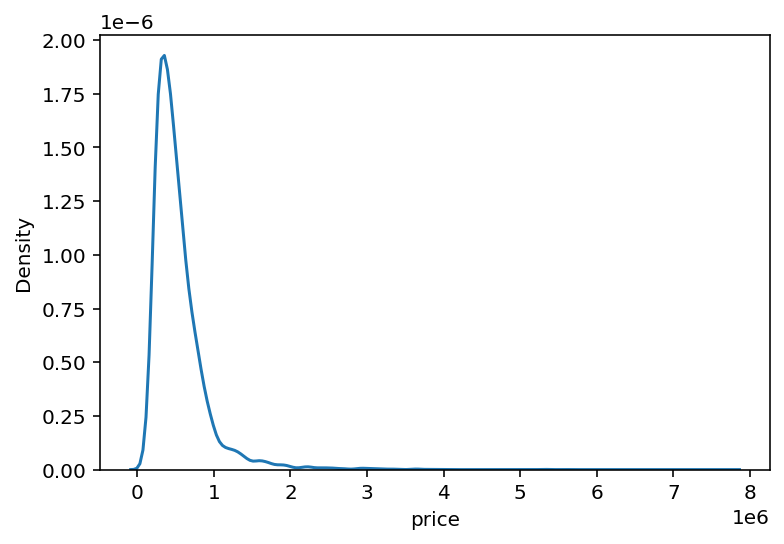

In [6]:
# 타겟 값인 Price가 정규분포가 아님 
sns.kdeplot(data=y)
plt.show()

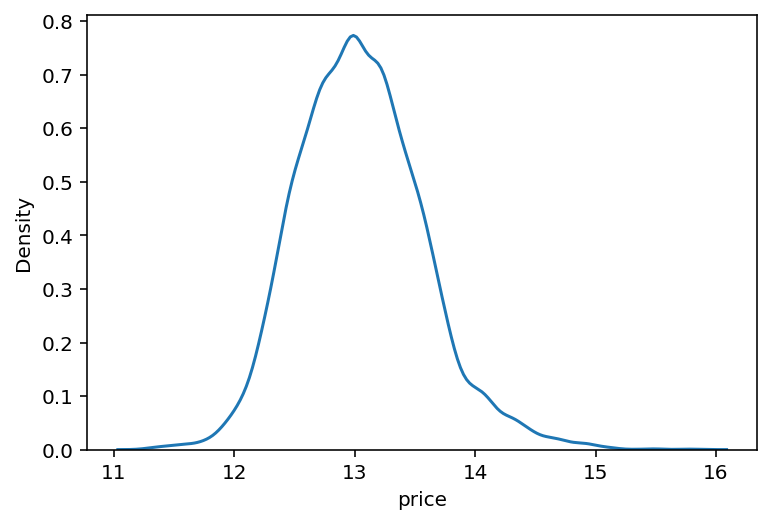

In [7]:
#타겟인 price 값을 log를 이용해 분포 변경
y = np.log1p(y)
sns.kdeplot(data=y)
plt.show()

# 모델 하이퍼 파라미터 튜닝

In [8]:
# 기본 모델 RMSE 값 확인
random_state=77

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,132422.932443
RandomForestRegressor,126654.047517
LGBMRegressor,116611.751734
XGBRegressor,113487.242840


In [9]:
# LGBM 부터 튜닝 시작 - XGB가 RMSE 값은 더 좋으나 훈련 시간이 적게 드는 LGBM 부터 시작함
model = LGBMRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'learning_rate': [0.001,0.01,0.1],
    'num_leaves' : [10,50,150,200]
}

result_df = my_GridSearch(model, train, y, param_grid)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [10]:
result_df

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
9,0.100,10,100,50,-0.026911,0.164045
10,0.100,10,100,150,-0.027416,0.165579
11,0.100,10,100,200,-0.027735,0.166538
8,0.100,10,100,10,-0.029988,0.173172
7,0.010,10,100,200,-0.070452,0.265428
6,0.010,10,100,150,-0.071148,0.266736
5,0.010,10,100,50,-0.076779,0.277090
4,0.010,10,100,10,-0.096493,0.310632
3,0.001,10,100,200,-0.236090,0.485891
2,0.001,10,100,150,-0.236370,0.486179


In [11]:
model = LGBMRegressor(max_depth=10, n_estimators=100, num_leaves=50,learning_rate=0.1,random_state=random_state)

save_submission(train_and_predict(model, train, y, test), 'lgbm', 'RMSLE_0.164045')


/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164045.csv saved!


### 최초 Submission 결과
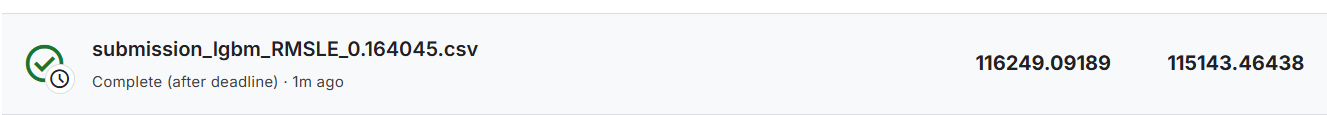
 - RMSLE 값이 가장 낮은 조합으로 최초 submission -> 기준치 충족 안됨
### 이후 파라미터 튜닝 진행  

 - 이후 RMSLE 값과 케글 score 가 어느정도 비례하는 것으로 보여 RMSLE 값을 충분히 낮추는 조합을 찾는 것을 반복함
 - 다른 모델에 대해서도 진행
 - 모든 조합 테스트에 대한 코드를 남기는 것은 비효율적이라 모델 별 최종 테스트만 남김
 - 최종적으로  n_estimators 10000 , learning_rate 0.05 선택 후 파라미터 튜닝 종료
 - 파라미터 튜닝만으로는 RMSLE 값이 충분히 낮아지지 않아 다른 시도 필요
 

In [12]:
model = LGBMRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [100,1000],
    'learning_rate': [0.05,0.1]
}

result_df = my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [13]:
result_df

,learning_rate,n_estimators,score,RMSLE
1,0.05,1000,-0.026047,0.161392
3,0.10,1000,-0.026767,0.163605
2,0.10,100,-0.027051,0.164472
0,0.05,100,-0.029068,0.170493


In [14]:
model = XGBRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [100,1000],
    'learning_rate': [0.05,0.1]
}

result_df = my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

In [15]:
result_df

,learning_rate,n_estimators,score,RMSLE
1,0.05,1000,-0.025817,0.160678
3,0.10,1000,-0.026714,0.163443
2,0.10,100,-0.027968,0.167236
0,0.05,100,-0.037326,0.193199


In [ ]:
model = GradientBoostingRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [100,1000],
    'learning_rate': [0.05,0.1]
}

result_df = my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
result_df

## 추가 시도

### 훈련 데이터들 일부 항목 log 연산
- price 만 log 연산하고 진행했었는데 노드 예제 첫번째에서 적용했던 항목들에 log 연산하여 개선 확인


In [ ]:
# 전체 항목 확인
check_dist(train, train.columns)

In [ ]:
# 필요 항목 log 연산
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

# 적용한 컬럼들 확인
check_dist(train, skew_columns)

## 모델별 개선 여부 확인
 - 일부 항목 로그 적용 및 하이퍼 파라미터 적용하여 각 모델의 RMSE 값이 향상되었음을 확인함

In [ ]:
gboost = GradientBoostingRegressor(random_state=random_state, n_estimators=1000,learning_rate=0.05)
xgboost = XGBRegressor(random_state=random_state, n_estimators=1000,learning_rate=0.05)
lightgbm = LGBMRegressor(random_state=random_state, n_estimators=1000,learning_rate=0.05)

models = [gboost, xgboost, lightgbm]

get_scores(models, train, y)

## AveragingBleding 적용
 - 3개 모델을 모두 적용하여 서브미션 해본 결과 기준치를 소폭 초과함
 - 가장 RMSE 가 안좋은 GBR 을 제외하고 2개만을 적용하여 기준치 달성

In [ ]:
save_submission(AveragingBlending(models,train,y,test), 'ABL_GLX', 'RMSE_113234_109327_108075')

In [ ]:

models = [lightgbm, xgboost]

save_submission(AveragingBlending(models,train,y,test), 'ABL_LX', 'RMSE_109327_108075')

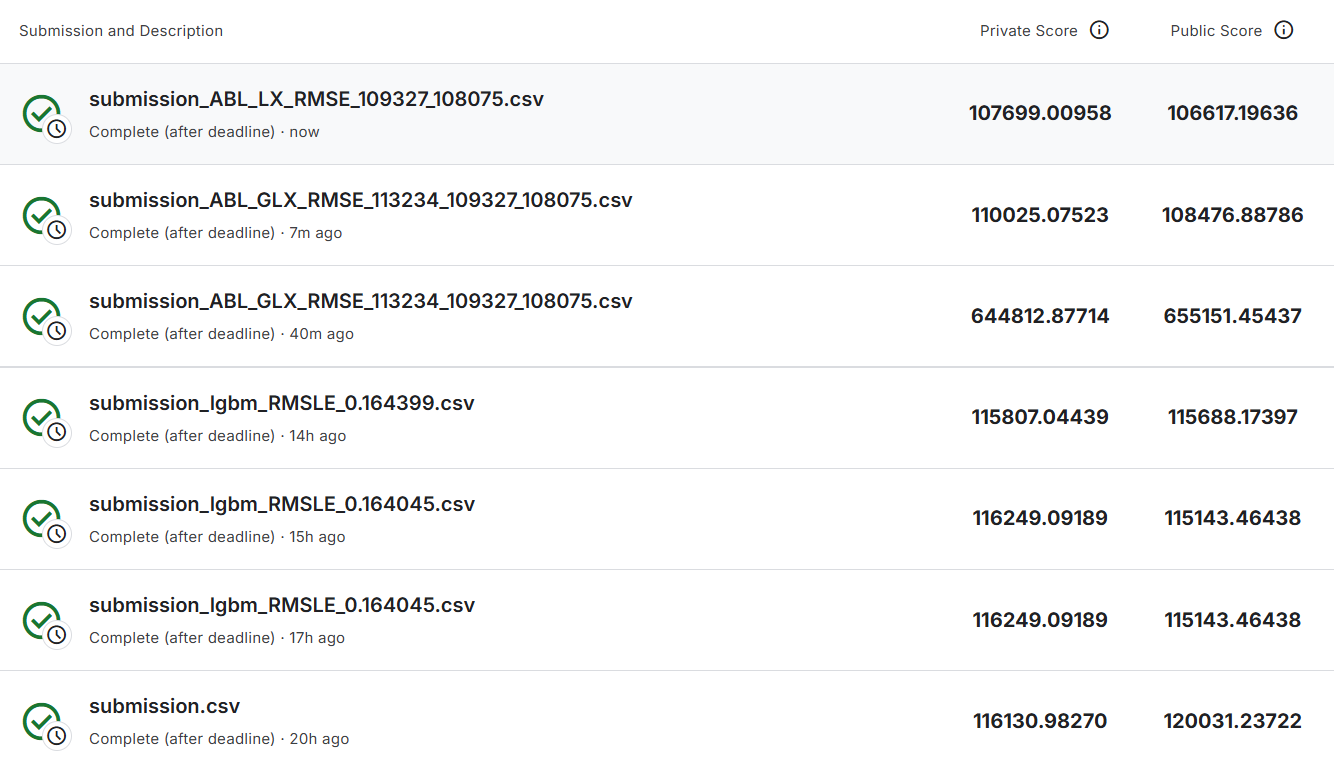

## 회고
'''
아는 게 많지 않아서 다양한 시도를 해보지는 못한거 같다. 
그래서 하이퍼 파라미터 튜닝에 너무 많은 시간을 쏟은거 같다는 생각이 든다. 
역설적으로 하이퍼파라미터 튜닝에 대해서 공부는 조금 된거 같다.
아직 모델이나 데이터에 대한 이해도가 높지 않지만 그래도 배운 내용을 이용해서 어떻게든 기준치를 충족시킨 점은 다행이다. 
케글에 공유되어있는 많은 커널들을 봤지만 봐도 내가 이해해서 적용할 수 있는 것들이 많지 않았다. 
EDA 과정에서 불필요한 데이터가 무엇인지 피쳐 엔지니어링은 어떻게 하는지 배워야 할 것이 많다고 느낀다.
비록 늦긴했지만 지난 번 프로젝트에 비해서 비교적 정돈되게 작성한 점은 나아진 부분이라고 보인다. 
submission 캡쳐를 보면 중간에 값이 크게 튀는 부분이 있는데 AveragingBlend를 처음 시도했을 때라 이 방법으로는 안되나 생각을 했었다
그렇다기엔 노드 예제보다에서 서브미션했을때보다 RMSE 값은 낮은데 이상해서 코드를 천천히 디버깅했다.
price 값에 log 함수를 했으므로 AveragingBlend 시 나오는 예측값이 log 된 값으로 저장되서 발생한 문제였다. 
데이터를 변환했으면 결과를 낼때는 제대로 변환에 대한 역 변환을 계속 고려해줘야겠다고 생각했다.
'''